## Introduction
A quick model to classify emotion in faces. This model is intended to be used for the Capstone Project in the Udacity C++ Nanodegree. The idea is first to build a working model using Keras/Tensorflow in Python, without worrying too much about optimising performance since the aim of this project is to showcase C++ programming. Then we will save the model checkpoints and deploy it for model inference using C++. 

## Model and Data Summary
- Data: Facial Emotion Recognition Dataset (FER) https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data
- Model Architecture: MobileNetV2 (lightweight for real-time)
- Pre-trained Model using ImageNet weights, fine-tuned to FER dataset  

**Note:** Model building process is very similar to this face mask detector transfer learning tutorial https://www.pyimagesearch.com/2020/05/04/covid-19-face-mask-detector-with-opencv-keras-tensorflow-and-deep-learning/, but just applying to the new dataset. However I am not using the Python API of OpenCV, I will be saving the model checkpoints and then deploying using the OpenCV and Tensorflow C++ APIs.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir
path = base_dir

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import pandas as pd

INIT_LR = 1e-3
EPOCHS = 100
BATCH_SIZE = 256

## Data Pre-processing and Augmentation

In [3]:
# Read in csv of pixel vectors, then convert to 48x48 numpy arrays
# Also make np array of labels
raw_data = pd.read_csv(path+"data/icml_face_data.csv")
raw_data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [4]:
raw_np = raw_data.values
raw_np.shape

(35887, 3)

In [0]:
images = np.array([np.reshape([int(s) for s in pic.split(' ')], (48,48)) for pic in raw_np[:,2]])
labels = raw_np[:,0].astype('int')

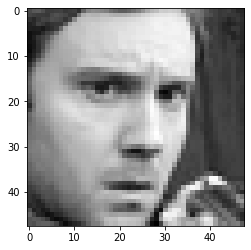

In [6]:
plt.imshow(images[0], cmap='gray')

In [0]:
images = preprocess_input(images) # normalises images

In [0]:
# # perform one-hot encoding on the labels
# lb = LabelBinarizer()
# labels = lb.fit_transform(labels)
# labels = to_categorical(labels)

In [0]:
# Split Train, Test, Val
train_images = np.stack((images[raw_np[:,1]=="Training"],)*3, axis=-1)
valid_images = np.stack((images[raw_np[:,1]=="PublicTest"],)*3, axis=-1)
test_images = np.stack((images[raw_np[:,1]=="PrivateTest"],)*3, axis=-1)

train_labels = labels[raw_np[:,1]=="Training"]
valid_labels = labels[raw_np[:,1]=="PublicTest"]
test_labels = labels[raw_np[:,1]=="PrivateTest"]

In [10]:
train_labels

array([0, 0, 2, ..., 4, 0, 4])

In [11]:
train_images.shape

(28709, 48, 48, 3)

## Keras Image Data Generator

In [0]:
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")


## Load Pre-Trained ImageNet Weights

In [13]:
baseModel = ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(48, 48, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

94773248/94765736 [==============================] - 1s 0us/step


In [0]:
baseModel.trainable = False

## Model Structure

In [0]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(2, 2))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
# headModel = Dropout(0.1)(headModel)
headModel = Dense(7, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## Train Model

In [17]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(optimizer=opt,
              loss="sparse_categorical_crossentropy", # sparse means the label input was just a vector of classes from 0-6
              metrics=["accuracy"])
history = model.fit(datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE), 
          steps_per_epoch=len(train_images) // BATCH_SIZE,
          validation_data=(valid_images, valid_labels),
          validation_steps=len(valid_images) // BATCH_SIZE,
          epochs=EPOCHS)#,
          # callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', patience=10)])

Epoch 1/100
112/112 [==============================] - 32s 283ms/step - loss: 1.7980 - accuracy: 0.3170 - val_loss: 1.6135 - val_accuracy: 0.3614
Epoch 2/100
112/112 [==============================] - 29s 259ms/step - loss: 1.6350 - accuracy: 0.3562 - val_loss: 1.6055 - val_accuracy: 0.3814
Epoch 3/100
112/112 [==============================] - 29s 258ms/step - loss: 1.6067 - accuracy: 0.3709 - val_loss: 1.5810 - val_accuracy: 0.3851
Epoch 4/100
112/112 [==============================] - 29s 259ms/step - loss: 1.5880 - accuracy: 0.3772 - val_loss: 1.5799 - val_accuracy: 0.3876
Epoch 5/100
112/112 [==============================] - 29s 259ms/step - loss: 1.5783 - accuracy: 0.3777 - val_loss: 1.5591 - val_accuracy: 0.3993
Epoch 6/100
112/112 [==============================] - 29s 258ms/step - loss: 1.5749 - accuracy: 0.3828 - val_loss: 1.5642 - val_accuracy: 0.3948
Epoch 7/100
112/112 [==============================] - 29s 258ms/step - loss: 1.5646 - accuracy: 0.3866 - val_loss: 1.5379 -

## Check Model Performance

In [18]:
predIdxs = model.predict(test_images, batch_size=BATCH_SIZE)
print(classification_report(test_labels, np.argmax(predIdxs, axis=1)))
model.save(path+'model_1', save_format="h5")

              precision    recall  f1-score   support

           0       0.31      0.31      0.31       491
           1       0.56      0.09      0.16        55
           2       0.40      0.16      0.23       528
           3       0.47      0.75      0.58       879
           4       0.41      0.32      0.36       594
           5       0.53      0.57      0.55       416
           6       0.41      0.38      0.39       626

    accuracy                           0.44      3589
   macro avg       0.44      0.37      0.37      3589
weighted avg       0.43      0.44      0.41      3589



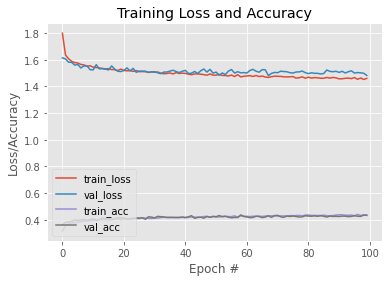

In [20]:
# plot the training loss and accuracy
N = 100
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")


## Save Model Checkpoints

In [0]:
model.save_weights(path+'model.ckpt')

In [22]:
model.save(path+'model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/model/assets


In [0]:
loaded_model = load_model(path+"model")

In [24]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [0]:
test_pred=model.predict(preprocess_input(test_images))

In [26]:
np.argmax(test_pred,axis=1)

array([4, 4, 4, ..., 4, 6, 6])